# EZKL Experiment

**Learning Objectives**
1. This is based off the ezkl-demo example provided by ezkl repo
2. Learn some basic AI/ML techniques by training a toy model in pytorch to perform classification (OPENSHS data in this example)
3. Convert the LSTM model into zk circuit with ezkl to do provable inference
4. Create a solidity verifier and deploy it on remix

**Important Note**: You might want to avoid calling "Run All". There's some file locking issue with Colab which can cause weird bugs. To mitigate this issue you should run cell by cell on Colab.

# Step 1: Training a LSTM model

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split


import os
import tqdm
from data import *
from dotenv import load_dotenv

In [62]:
# Load environment variables
load_dotenv()
base_path = os.environ.get("ICBC25_PATH")
data_path = os.path.join(base_path, "data/openshs-classification/")

ACTIVITIES = ['sleep', 'eat', 'personal', 'work', 'leisure', 'other']
WINDOW_SIZE = 15
LABEL_AHEAD = 1

data = data_path + "d1_2m_0tm.csv"
d = DATASET()  
d.load_data(data, ACTIVITIES)
train_data, test_data = d.split_data(test_percentage=0.2)
trainX, trainY, activity_mapping  = d.form_data(train_data, WINDOW_SIZE, LABEL_AHEAD)
testX, testY, activity_mapping  = d.form_data(test_data, WINDOW_SIZE, LABEL_AHEAD)

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

# convert the dataset to Tensor format
trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
testX_tensor = torch.tensor(testX, dtype=torch.float32)

# convert one-hot encoded labels to class indices
trainY_tensor = torch.argmax(torch.tensor(trainY, dtype=torch.float32), dim=1)
testY_tensor = torch.argmax(torch.tensor(testY, dtype=torch.float32), dim=1)

# convert to tensordataset
train_tensor = TensorDataset(trainX_tensor, trainY_tensor)
test_tensor = TensorDataset(testX_tensor, testY_tensor)

(30548, 15, 29) (30548, 6)
(7626, 15, 29) (7626, 6)


In [63]:
class LSTM(nn.Module):
    def __init__(self, window_size, num_features, num_categories):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=num_features, hidden_size=32, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(32, num_categories)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x[:, -1, :])  # take the last output for classification
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [64]:
class Histories:
    def __init__(self):
        self.history = {'loss': [], 'f1': [], 'accuracy': []}
    
    def update(self, loss_value=None, f1_value=None, accuracy_value=None):
        if loss_value is not None:
            self.history['loss'].append(loss_value)
        if f1_value is not None:
            self.history['f1'].append(f1_value)
        if accuracy_value is not None:
            self.history['accuracy'].append(accuracy_value)

    def get_history(self):
        return self.history

In [65]:
def plot_metrics(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 6))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs')
    plt.legend()
    
    # Plot F1 Score and Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['f1'], label='Validation F1 Score')
    plt.plot(epochs, history['accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('F1 Score & Accuracy vs Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [66]:
def train_model(train_tensor, test_tensor, model, batch_size, epochs, optimizer, loss_fn, histories):
    
    # create DataLoader for batching
    train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=False)    

    # train
    for epoch in tqdm.trange(epochs):
        running_loss = 0.0
        
        # Training loop
        model.train()  # set model to training mode
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # clear gradients
            
            # forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            # backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        histories.update(loss_value=avg_loss)  # update history with training loss

        # Evaluation
        model.eval()  # set model to evaluation mode
        all_preds = []
        all_labels = []
        with torch.no_grad():  # Disable gradient calculation for evaluation
            for inputs, labels in test_loader:
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate F1 and accuracy for validation
        f1 = f1_score(all_labels, all_preds, average='macro')  # F1 score
        accuracy = accuracy_score(all_labels, all_preds)  # Accuracy
        histories.update(f1_value=f1, accuracy_value=accuracy)  # Update history with F1 and accuracy

        # print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, F1: {f1:.4f}, Accuracy: {accuracy:.4f}')
        # model.train()  # Switch back to training mode for next epoch

    # # Export the trained model to ONNX after training
    # if save_onnx:
    #     # Prepare a sample input (batch size 1) for the ONNX export
    #     input_sample = torch.randn(1, trainX.shape[1], trainX.shape[2])
    #     torch.onnx.export(model, input_sample, onnx_filename, export_params=True, opset_version=11,
    #                       input_names=['input'], output_names=['output'],
    #                       dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
    #     print(f"Model exported to {onnx_filename}")
    
    return histories.get_history()

15 29 6


100%|██████████| 20/20 [04:01<00:00, 12.07s/it]


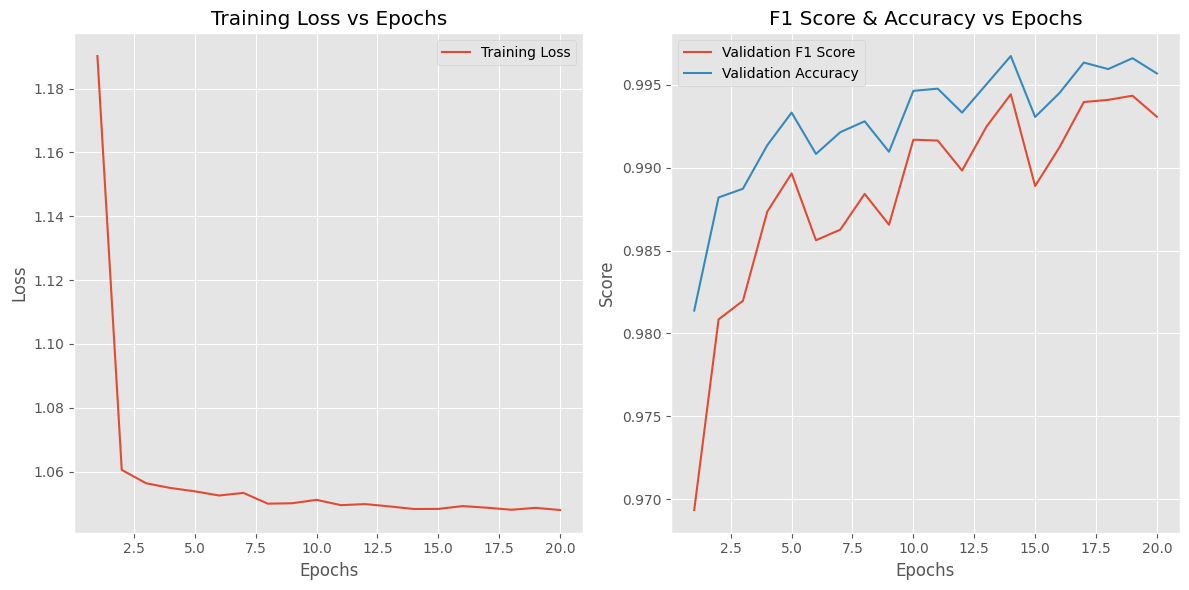

In [68]:
model = LSTM(trainX.shape[1], trainX.shape[2], trainY.shape[1])
print(trainX.shape[1], trainX.shape[2], trainY.shape[1])
history = train_model(
                    train_tensor, 
                    test_tensor, 
                    model=model, 
                    batch_size=10,
                    epochs=20, 
                    optimizer=torch.optim.Adam(model.parameters(), lr=0.001),
                    loss_fn=nn.CrossEntropyLoss(),
                    histories=Histories()
            )

plot_metrics(history)

# Step 2: ZK the Neural Network (Halo2)

In [69]:
import os
import json
import ezkl
import time
from timeit import default_timer as timer

In [70]:
# Specify all the files we need
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
data_path = os.path.join('input.json')
settings_path = os.path.join('settings.json')
cal_data_path = os.path.join('calibration.json')
witness_path = os.path.join('witness.json')

pk_path = os.path.join('pk.key')
vk_path = os.path.join('vk.key')

# ---- Key time measurements for the experiment ----

In [89]:
# Flips the neural net into inference mode
model.eval()

# Export the model
torch.onnx.export(model,                     # model being run
                  torch.randn(1, 15, 29),    # model input (or a tuple for multiple inputs)
                  model_path,                # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

# Parameters
SEQ_LEN = 1  # Batch size for calibration
input_shape = (SEQ_LEN, trainX.shape[1], trainX.shape[2])  # [batch_size, 15, 29]
x = torch.randn(*input_shape)
data_array = ((x).detach().numpy()).reshape([-1]).tolist()
data_json = dict(input_data = [data_array])
print(data_json)
# Serialize data into file:
json.dump( data_json, open(data_path, 'w' ))

# Compile the circuit
start = timer()

# Generate calibration data
calibration_input = torch.randn(*input_shape)
data_array = calibration_input.detach().numpy().reshape([-1]).tolist()
calibration_data = dict(input_data=[data_array])

# Serialize calibration data to file
json.dump(calibration_data, open(cal_data_path, "w"))

# Run arguments for ezkl
run_args = ezkl.PyRunArgs()
run_args.variables = [("batch_size", SEQ_LEN)]  # Set batch size

# Generate ezkl settings
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True
print("Settings generated successfully.")

# Calibrate settings
res = await ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources")
assert res == True
print("Calibration completed successfully.")

res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True
print(f"Compile time: {timer() - start:.4f} seconds")

{'input_data': [[2.1740260124206543, 1.5715450048446655, 0.7518166899681091, -1.7759965658187866, 0.1443580538034439, -0.3938485085964203, 0.03480149060487747, 0.9983670711517334, -0.28379392623901367, -0.7491317391395569, -1.1484699249267578, 2.0258445739746094, 0.18385179340839386, 0.40950730443000793, 1.308642029762268, 0.49238213896751404, 0.9373497366905212, -0.018897920846939087, -0.8975223898887634, -1.2730612754821777, 0.08738871663808823, -1.1596558094024658, -1.205270767211914, 0.32883670926094055, 1.2445614337921143, -1.776907205581665, -1.1458383798599243, -0.08102808147668839, 1.2410438060760498, -0.1967238485813141, 1.204136848449707, -0.608171284198761, -0.9246098399162292, 1.0796692371368408, 0.5155728459358215, -1.7448992729187012, -0.5267559289932251, 0.15536879003047943, 1.06743586063385, 0.6439613699913025, 0.6484114527702332, 2.229217290878296, -0.45147743821144104, -0.25792843103408813, 0.2892643213272095, -0.7283487319946289, 1.266226887702942, -0.525412380695343

Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 6 columns for non-linearity table.
Using 6 columns for non-linearity table.
Using 6 columns for non-linearity table.
Using 6 columns for non-linearity table.
Using 6 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.
Using 11 columns for non-linearity table.


 <------------- Numerical Fidelity Report (input_scale: 11, param_scale: 11, scale_input_multiplier: 1) ------------->

+--------------------+---------------------+----

Calibration completed successfully.
Compile time: 21.6484 seconds


In [90]:
# Witness Gen
start = timer()
res = await ezkl.get_srs( settings_path )

res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

res = ezkl.mock(witness_path, compiled_model_path)
assert res == True
print(f"Witness Gen time: {timer() - start:.4f} seconds")

Witness Gen time: 4.1271 seconds


In [86]:
# Proof setup
os.environ["RUST_LOG"] = "trace"
start = timer()
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )
assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)
print(f"Setup time: {timer() - start:.4f} seconds")

Setup time: 24.6927 seconds


In [77]:
# GENERATE A PROOF
start = timer()
proof_path = os.path.join('test.pf')
proof = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )
print(proof)
assert os.path.isfile(proof_path)
print(f"Proof time: {timer() - start:.4f} seconds")

{'instances': [['0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0000000000000000000000000000000000000000000000000000000000000000', '0010000000000000000000000000000000000000000000000000000000000000']], 'proof': '0x12b4c5443113de36a5ed003b369df1ce05aac175944f479cac97990ea1fac7be231100b337de507bfaeceb4f24f6774447c997ebf038e2691d31d8aa11202cd1278e61370212b465af83c0b508942296547d9893a0b93f1676eb7e84fdf30c9b1e2d4069aece63f2830e6b8347d3c658d543bd9d0a640c696927705a4334f98216bed286ae7c961db997cd1db99614c4409ca5636a817c8f5e68921c899267e801e578c468d23aae763acfbb090301dba7414ad89eb080b441024fded508822a2692cbfbb92fccbf39653431f275fa412349a7e86bb12741a5891d862f7399ba0b89535bf1173c89ff00bec9cce2e4cfcacd7d8eb0e3a3f2c4765df7608dcdbb240eb904dd8bf55bc6cfa2d3201c00f17212d369a7c03bf9f7

In [78]:
# VERIFY IT
start = timer()
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )
assert res == True
print("verified")
print(f"Verify (local) time: {timer() - start:.4f} seconds")

verified
Verify (local) time: 0.1893 seconds


In [79]:
# CREATE VERIFIER CONTRACT
sol_code_path = os.path.join('Verifier-lstm.sol')
abi_path = os.path.join('Verifier-lstm.abi')

res = await ezkl.create_evm_verifier(
        sol_code_path=sol_code_path,
        abi_path=abi_path, 
    )

assert res == True
assert os.path.isfile(sol_code_path)

In [80]:
# GENERATE EXAMPLE VERIFIERS
onchain_input_array = []
# using a loop
# avoiding printing last comma
formatted_output = "["
for i, value in enumerate(proof["instances"]):
    for j, field_element in enumerate(value):
        onchain_input_array.append(ezkl.felt_to_big_endian(field_element))
        formatted_output += '"' + str(onchain_input_array[-1]) + '"'
        if j != len(value) - 1:
            formatted_output += ", "
    if i != len(proof["instances"]) - 1:
        formatted_output += ", "
formatted_output += "]"

# This will be the values you use onchain
# copy them over to remix and see if they verify
# What happens when you change a value?
print("pubInputs: ", formatted_output)
print("proof: ", proof["proof"])

pubInputs:  ["0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000000000", "0x0000000000000000000000000000000000000000000000000000000000001000"]
proof:  0x12b4c5443113de36a5ed003b369df1ce05aac175944f479cac97990ea1fac7be231100b337de507bfaeceb4f24f6774447c997ebf038e2691d31d8aa11202cd1278e61370212b465af83c0b508942296547d9893a0b93f1676eb7e84fdf30c9b1e2d4069aece63f2830e6b8347d3c658d543bd9d0a640c696927705a4334f98216bed286ae7c961db997cd1db99614c4409ca5636a817c8f5e68921c899267e801e578c468d23aae763acfbb090301dba7414ad89eb080b441024fded508822a2692cbfbb92fccbf39653431f275fa412349a7e86bb12741a5891d862f7399ba0b89535bf1173c89ff00bec9cce2e4cfcacd7d8eb0e3a3f2c4765df7608dcdbb240eb904dd8bf55bc6cfa2d3201c00f17212d369a7c03

# --- Legacy ----

In [ ]:
# # After training, export to onnx (network.onnx) and create a data file (input.json)
# start = timer()

# # create a random input
# # x = testX_tensor[0]
# x = torch.randn(1, trainX.shape[1], trainX.shape[2])

# # Flips the neural net into inference mode
# model.eval()

# # Export the model
# torch.onnx.export(model,                     # model being run
#                   x,                         # model input (or a tuple for multiple inputs)
#                   model_path,                # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=10,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}})

# data_array = ((x).detach().numpy()).reshape([-1]).tolist()

# data = dict(input_data = [data_array])

#     # Serialize data into file:
# json.dump(data, open(data_path, 'w'))

# # !RUST_LOG=trace
# # # TODO: Dictionary outputs
# # res = ezkl.gen_settings()
# # assert res == True

# # # Optimize for resources, we cap logrows at 12 to reduce setup and proving time, at the expense of accuracy
# # # You may want to increase the max logrows if accuracy is a concern
# # res = await ezkl.calibrate_settings(target = "resources", max_logrows = 12, scales = [2])

# run_args = ezkl.PyRunArgs()
# run_args.variables = [("batch_size", 15)]

# # TODO: Dictionary outputs
# res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
# assert res == True

# res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
# assert res == True

# cal_path = os.path.join("calibration.json")

# # data_array = (torch.randn(10, *shape).detach().numpy()).reshape([-1]).tolist()

# data = dict(input_data = [data_array])

# # Serialize data into file:
# json.dump(data, open(cal_path, 'w'))

# # ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")



# res = ezkl.compile_circuit()
# compile_time = timer() - start
# print(f"Compile time: {compile_time:.4f} seconds")


In [ ]:
# # Measure setup time
# start = timer()
# res = await ezkl.get_srs()
# res = ezkl.setup()
# setup_time = timer() - start

# print(f"Setup time: {setup_time:.4f} seconds")


In [ ]:
# # Measure witness compute time
# witness_path = os.path.join('witness.json')

# start = timer()
# res = await ezkl.gen_witness()
# witness_time = timer() - start
# assert os.path.isfile(witness_path)

# print(f"Witness computation time: {witness_time:.4f} seconds")


In [ ]:
# proof_path = os.path.join('proof.json')

# # Measure proof generation time
# start = timer()
# proof = ezkl.prove(proof_type="single", proof_path=proof_path)
# proof_time = timer() - start
# assert os.path.isfile(proof_path)

# print(f"Proof generation time: {proof_time:.4f} seconds")

In [ ]:
# with open('settings.json', 'r') as f:
#     settings = json.load(f)
#     print(json.dumps(settings, indent=2))


In [ ]:
# # verify our proof

# res = ezkl.verify()

# assert res == True
# print("verified")

You should see a `Verifier.sol`. Right-click and save it locally.

### truffle deployment
1. create  an empty directory `truffle`
2. inside `/truffle`, `truffle init`
3. `truffle compile` after finishing the contract
4. `truffle migrate` after config `truffle-config.js`
5. use python- `web3` to interact


### remix deployment
Now go to [https://remix.ethereum.org](https://remix.ethereum.org).

Create a new file within remix and copy the verifier code over.

Finally, compile the code and deploy. For the demo you can deploy to the test environment within remix.

If everything works, you would have deployed your verifer onchain! Copy the values in the cell above to the respective fields to test if the verifier is working.

**Note that right now this setup accepts random values!**

This might not be great for some applications. For that we will want to use a data attested verifier instead. [See this tutorial.](https://github.com/zkonduit/ezkl/blob/main/examples/notebooks/data_attest.ipynb)